## <center>Home Assignment #4:  Community Detection Algorithms </center>

### <center>Student: *Ivanova Polina*</center>

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
import pandas as pd
import scipy.sparse

## Problems
### Task 1

Implementing of [Markov Cluster Algorithm](http://micans.org/mcl/) (MCL).

**Input:** Transition matrix $T = D^{-1}A$

**Output:** Adjacency matrix $M^*$

1. Set $M = T$
2. **repeat:**
    3. *Expansion Step:* $M = M^p$ (usually $p=2$)
    4. *Inflation Step:* Raise every entry of $M$ to the power $\alpha$ (usualy $\alpha=2$)
    5. *Renormalize:* Normalize each row by its sum
    6. *Prunning:* Replace entries that are close to $0$ by pure $0$
7. **until** $M$ converges
8. $M^* = M$
<br\>
<br\>

As a result you should get a cluster matrix s.t. elements of the cluster correspont to nonzero elements of the columns of the matrix. 
<br\>
* Run this method for network [1](https://www.hse.ru/data/2016/03/15/1127695811/network1.mat), [2](https://www.hse.ru/data/2016/03/15/1127699956/network2.mat) and [3](https://www.hse.ru/data/2016/03/15/1127703057/network3.mat).
* Play with the parameters ($p$, $\alpha$, zero tolerance), analyse the results

<hr />


In [10]:
def mcl(G = None, A = None, p = 2, alpha = 2, zero_tolerance = 0):
    if G:
        A = nx.adjacency_matrix(G)
    degrees = A.sum(axis = 0)
    #f = lambda x: 1./x if (x != 0) else 0
    #D_inv =  np.diag([f(i) for i in degrees])
    T = A / degrees[None, :]
    M = T
    k = 1
    eps = 100
    while (eps > 0):
        M1 = np.linalg.matrix_power(M, p)
        M1 = np.power(M1, alpha)
        degrees = M1.sum(axis = 0)
        #D_inv =  np.diag([f(i) for i in degrees])
        M1 = M1 / degrees[None, :]
        M1[M1 <= zero_tolerance] = 0
        eps = np.linalg.norm(M - M1)
        #print 'step ', k, ': ', eps
        k += 1
        M = M1.copy()
    
    return M1

#### Dataset № 1
Let's look to the first data. Futher there are several plots: plot of initial adjacency matrix (A1), plot of adjacency matrix returning by Markov Cluster Algorithm (M1) and plot of graph divided to classes according to the Markov Cluster Algorithm. 

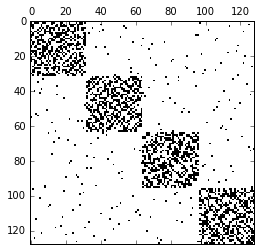

In [8]:
net1 = scipy.io.loadmat('network1.mat')
A1 = net1['A'].astype('float')
plt.spy(A1)
comm = net1['Comm']

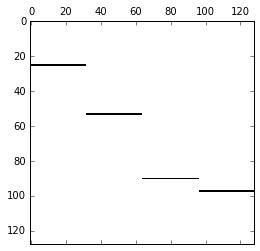

In [11]:
M1 = mcl(A = A1, p = 2, alpha = 2, zero_tolerance = 0.01)
plt.spy(M1)

Here standard values for parameters for p and alpha leads to right division on communities.

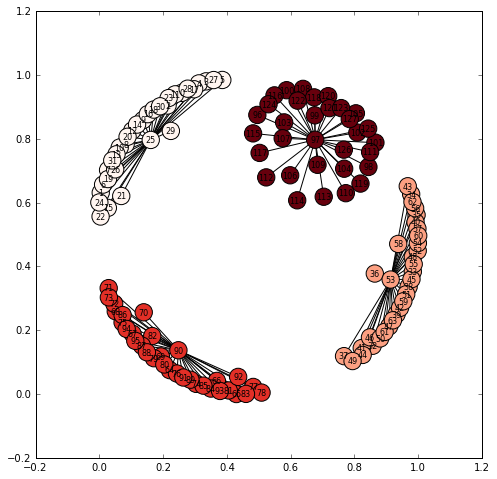

In [14]:
G1 = nx.from_numpy_matrix(M1)
k = nx.degree(G1)
plt.figure(1, figsize=(8,8))
coord = nx.spring_layout(G1)
nx.draw_networkx(G1,
                 pos=coord,
                 nodelist=k.keys(),
                 #node_size = [d*100 for d in k.values()],
                 node_color=comm,
                 font_size=8,
                 cmap=plt.cm.Reds,
                 )

#### Dataset № 2
For the second datadet we draw the same plots:
* plot of initial adjacency matrix (A2), 
* plot of adjacency matrix returning by Markov Cluster Algorithm (M2), 
* plot of graph divided to classes according to the Markov Cluster Algorithm. 

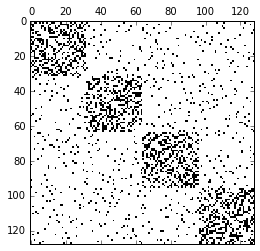

In [15]:
net2 = scipy.io.loadmat('network2.mat')
A2 = net2['A'].astype('float')
plt.spy(A2)
comm2 = net2['Comm']

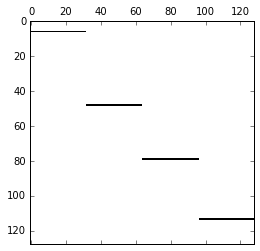

In [16]:
M2 = mcl(A =A2, p = 2, alpha = 1.5, zero_tolerance = 0.01)
plt.spy(M2)

Take parameters as in the cell above we take strict division to the communities, which is right (as one can see on the plot further)

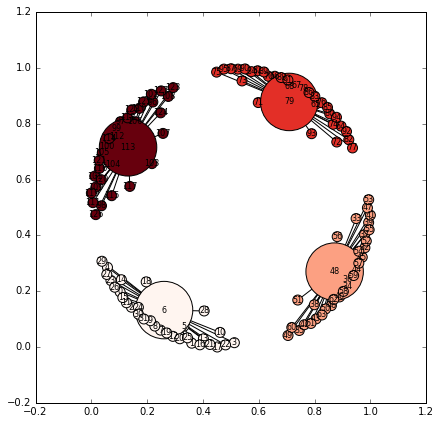

In [21]:
G2 = nx.from_numpy_matrix(M2)
k = nx.degree(G2)
plt.figure(1, figsize=(7,7))
coord = nx.spring_layout(G2)
nx.draw_networkx(G2,
                 pos=coord,
                 nodelist=k.keys(),
                 node_size = [d*100 for d in k.values()],
                 node_color=comm2,
                 font_size=8,
                 cmap=plt.cm.Reds,
                 )

#### Dataset № 3
Here we will draw the same plots. But for this dataset we will not obtain the strict division as in previous examples. Let's look.

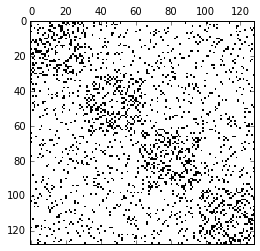

In [22]:
net3 = scipy.io.loadmat('network3.mat')
A3 = net3['A'].astype('float')
plt.spy(A3)
comm3 = net3['Comm']

If we take p = 2, we well obtain division by classes with single vertex in each. This is obviously incorrect.

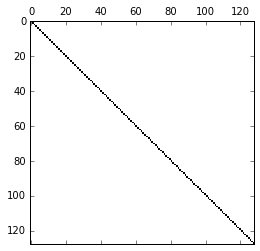

In [116]:
M3 = mcl(A = A3, p = 2, alpha = 5, zero_tolerance = 0.01)
plt.spy(M3)

For such parameters (as in cell below) the division is not clear. But, in my opinion, this is quite good result 	in comparison with other parameters which I tried.

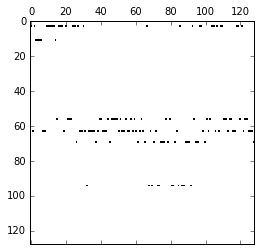

In [121]:
M3 = mcl(A = A3, p = 3, alpha = 3, zero_tolerance = 0.01)
plt.spy(M3)

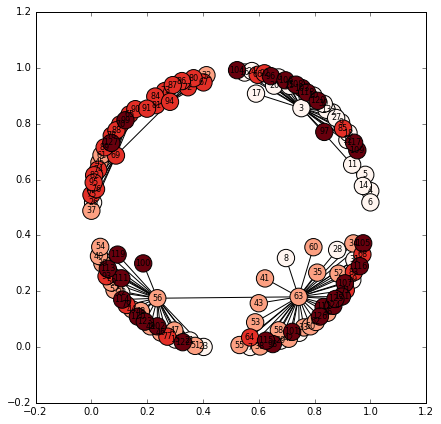

In [122]:
G3 = nx.from_numpy_matrix(M3)
k = nx.degree(G3)
plt.figure(1, figsize=(7,7))
coord = nx.spring_layout(G3)
nx.draw_networkx(G3,
                 pos=coord,
                 nodelist=k.keys(),
                 #node_size = [d*100 for d in k.values()],
                 node_color=comm2,
                 font_size=8,
                 cmap=plt.cm.Reds,
                 )

### Task 2

Load [Yahoo Music network](https://www.hse.ru/data/2016/03/15/1127704844/music_data.mat). Edges in this network appear if enough number of users have given ratings to both music bands. Note, that edges are weighted with similarity of the ratings.

* Implement *multilevel spectral recursive partitioning* algorithm that was described during the lecture
* Visualize community structure of the network and output some of the dense clusters (with interpretation, if you can)

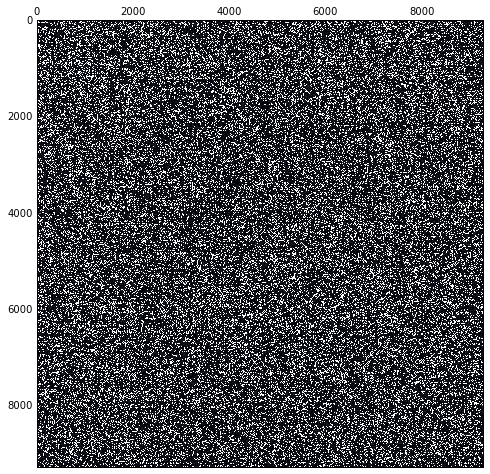

In [139]:
music_data = scipy.io.loadmat('music_data.mat')
A = music_data['A'].astype('float')
A[A>0]=1
A[A<0]=0
plt.figure(1, figsize=(8,8))
plt.spy(A,markersize=0.5)

In [149]:
def density(A):
    # density of G(n,m) is equal to m/(n*(n-1)*2)
    # number of non-zero elements in adjacency matrix = 2*m
    n = A.shape[0]
    return len(A.nonzero()[0]) / (1.* n * (n-1))

print density(A)

0.00349374498023


I was not make in time the recursive method. Here there is implementation of one step of algorithm, which return 2 classes

In [162]:
def spectral_partitioning(A):
    A = scipy.sparse.csr_matrix(A)
    degrees = A.sum(axis = 0)
    D =  np.diag(degrees.tolist()[0])
    D = scipy.sparse.csr_matrix(D)
    L = D - A
    #futher k = 200 becaue then we increase k, we can find smaller eigenvalues
    w, v = scipy.sparse.linalg.eigsh(L, k = 2) 
    if w[0] == 0:
        eigvec = v[:, 1]
    else:
        eigvec = v[:, 1]
    #futher we will sort eigvec and find the division of vertices to the two classes
    order = np.argsort(eigvec) 
    A = A[:,order]
    A = A[order, :]
    s = np.sign(eigvec[order]) #indicator of classes: -1, ..., -1, 1, ..., 1
    div_position = list(s).index(1) 
    #Divide into 2 classes
    vminus = A[:div_position, :div_position]
    vplus = A[div_position:, div_position:]
    return vplus, vminus